In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from torchvision.transforms import Lambda
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class CustomDataset(Dataset):
    def __init__(self, file_path, transform=None):
        data = pd.read_csv(file_path)
        self.features = data.drop(columns=['objid', 'specobjid', 'class', 'run', 'rerun', 'camcol', 'field', 'ra', 'dec', 'redshift'], axis=1)
        self.labels = data['class']
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features.iloc[index]
        label_str = self.labels.iloc[index]

        # Convert label string to integer
        if label_str == 'GALAXY':
            label = 0
        elif label_str == 'STAR':
            label = 1
        else:
            label = 2
        
        feature = torch.tensor(feature, dtype=torch.float32).to(device) 
        label = torch.tensor(label, dtype=torch.long).to(device)  


        if self.transform is not None:
        
            feature = self.transform(feature)

        return feature, label


In [3]:
transform = Lambda(lambda x: (x - x.mean()) / x.std())
csv_file = 'photofeatures_exp3.csv'
dataset = CustomDataset(csv_file,transform=transform)
X = []
y = []

for i in range(len(dataset)):
    feature, label = dataset[i]
    X.append(feature)
    y.append(label)

X = torch.stack(X)
y = torch.stack(y)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, random_state=42)
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).long().to(device)
X_val = torch.Tensor(X_val).to(device)
y_val = torch.Tensor(y_val).long().to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test).long().to(device)

In [5]:
model = GaussianNB()

In [6]:
model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())

GaussianNB()

In [7]:
y_val_pred = model.predict(X_val.cpu().numpy())
y_val = y_val.cpu().numpy()
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.6492997198879552


In [8]:
names = {0:'GALAXY',1:'STAR',2:'QSO'}
y_test_pred = model.predict(X_test.cpu().numpy())
y_test = y_test.cpu().numpy()


In [9]:
accuracytest = accuracy_score(y_test, y_test_pred)
print("Test Accuracy for naive bayes:", accuracytest)

Test Accuracy for naive bayes: 0.6498458088029156


In [10]:
precisionnb = precision_score(y_test,y_test_pred, average='weighted',zero_division =0 )
recallnb = recall_score(y_test,y_test_pred, average='weighted')

print("Precision:", precisionnb)
print("Recall:", recallnb)

Precision: 0.7050210295877909
Recall: 0.6498458088029156


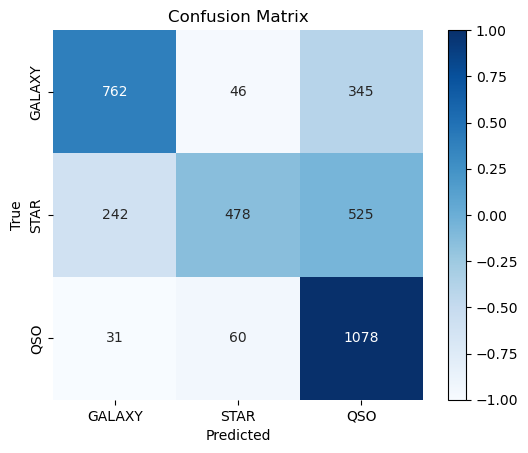

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_test_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
class_names = ['GALAXY', 'STAR', 'QSO']
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
dummy = plt.imshow([[-1, -1], [1, 1]], cmap='Blues')
plt.colorbar(dummy)
plt.show()